# Concrete Compressive Testing

The Compressive Strength of Concrete determines the quality of Concrete. This is generally determined by a standard crushing test on a concrete cylinder. This requires engineers to build small concrete cylinders with different combinations of raw materials and test these cylinders for strength variations with a change in each raw material. The recommended wait time for testing the cylinder is 28 days to ensure correct results. This consumes a lot of time and requires a lot of labour to prepare different prototypes and test them. Also, this method is prone to human error and one small mistake can cause the wait time to drastically increase.

One way of reducing the wait time and reducing the number of combinations to try is to make use of digital simulations, where we can provide information to the computer about what we know and the computer tries different combinations to predict the compressive strength. This way we can reduce the number of combinations we can try physically and reduce the amount of time for experimentation. But, to design such software we have to know the relations between all the raw materials and how one material affects the strength. It is possible to derive mathematical equations and run simulations based on these equations, but we cannot expect the relations to be same in real-world. Also, these tests have been performed for many numbers of times now and we have enough real-world data that can be used for predictive modelling.

## Import Necessary Library

In [68]:
%matplotlib inline
!pip install pyforest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pyforest import *

import warnings
warnings.filterwarnings('ignore')

In [69]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.utils import resample

## Loading dataset from UCI

In [70]:
df = pd.read_csv(r"C:\Users\User\Desktop\DATA SETS\Concrete_Data (1).csv")


<IPython.core.display.Javascript object>

In [71]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [72]:
df.shape

(1030, 9)

In [73]:
df = df.rename(columns={"Cement (component 1)(kg in a m^3 mixture)":"cement",
                        "Blast Furnace Slag (component 2)(kg in a m^3 mixture)":"slag",
                        "Fly Ash (component 3)(kg in a m^3 mixture)":"ash",
                        "Water  (component 4)(kg in a m^3 mixture)":"water",
                        "Superplasticizer (component 5)(kg in a m^3 mixture)":"superplastic",
                        "Coarse Aggregate  (component 6)(kg in a m^3 mixture)":"coarseagg",
                        "Fine Aggregate (component 7)(kg in a m^3 mixture)":"fineagg",
                        "Age (day)":"age",
                        "Concrete compressive strength(MPa, megapascals) ":"strength"})

In [74]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [76]:
df.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [77]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


## Exploratry Data Analysis

In [78]:
from scipy import stats

# Cement
Q1 = df['cement'].quantile(q=0.25)
Q3 = df['cement'].quantile(q=0.75)
print('1st quantile: ' , Q1 )
print('3rd quantile: ' , Q3 )
print('Interquantile range (IQR): ' , stats.iqr(df['cement']))

1st quantile:  192.375
3rd quantile:  350.0
Interquantile range (IQR):  157.625


In [79]:
L_outlier = Q1-1.5*(Q3-Q1)
U_outlier = Q3+1.5*(Q3-Q1)
print('Lower outlier limit in cement: ', L_outlier)
print('Upper outlier limit in cement: ', U_outlier)

Lower outlier limit in cement:  -44.0625
Upper outlier limit in cement:  586.4375


In [80]:
print('Number of outlier in cement Upper: ',df[df['cement']>586.4375]['cement'].count())
print('Number of outlier in cement Lower: ',df[df['cement']<-44.0625]['cement'].count())

Number of outlier in cement Upper:  0
Number of outlier in cement Lower:  0


<IPython.core.display.Javascript object>

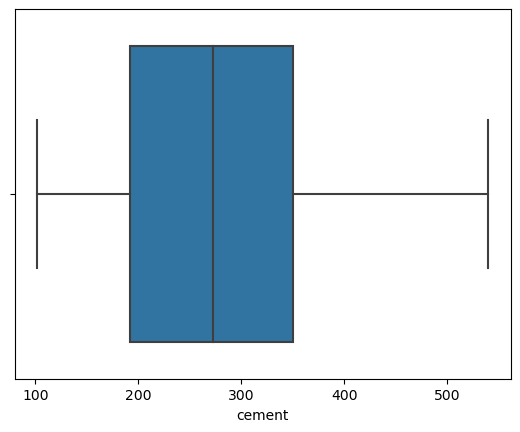

In [81]:
sns.boxplot(x='cement',data=df);

<IPython.core.display.Javascript object>

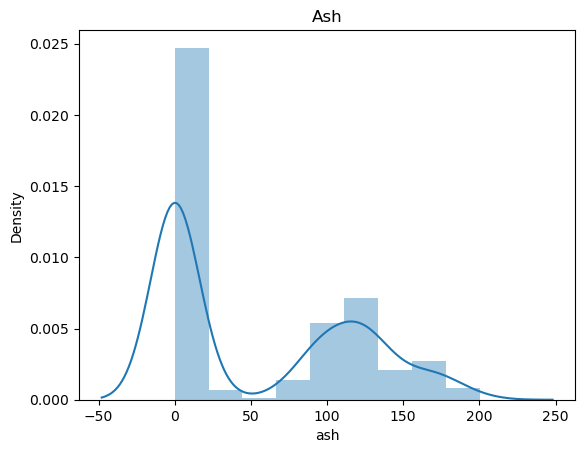

In [82]:
# Ash
sns.distplot(df['ash']).set_title('Ash');

In [83]:
# Water
W_Q1 = df['water'].quantile(q=0.25)
W_Q3 = df['water'].quantile(q=0.75)
print('1st quantile: ' , W_Q1 )
print('3rd quantile: ' , W_Q3 )
print('Interquantile range (IQR): ' , stats.iqr(df['water']))

1st quantile:  164.9
3rd quantile:  192.0
Interquantile range (IQR):  27.099999999999994


In [84]:
WL_outlier = W_Q1-1.5*(W_Q3-W_Q1)
WU_outlier = W_Q3+1.5*(W_Q3-W_Q1)
print('Lower outlier limit in cement: ', WL_outlier)
print('Upper outlier limit in cement: ', WU_outlier)

Lower outlier limit in cement:  124.25000000000001
Upper outlier limit in cement:  232.64999999999998


In [85]:
print('Number of outlier in cement Upper: ',df[df['water']>232.65]['water'].count())
print('Number of outlier in cement Lower: ',df[df['water']<124.25]['water'].count())

Number of outlier in cement Upper:  4
Number of outlier in cement Lower:  5


<IPython.core.display.Javascript object>

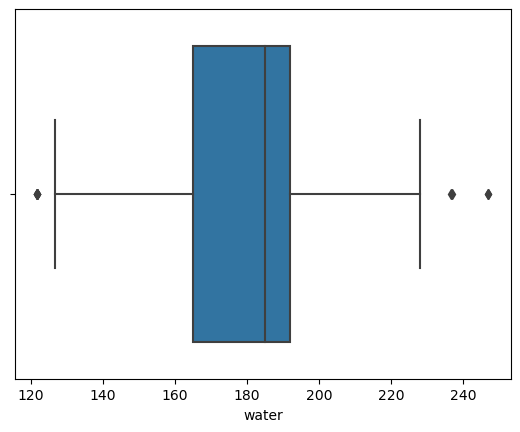

In [86]:
sns.boxplot(x='water',data=df);

<IPython.core.display.Javascript object>

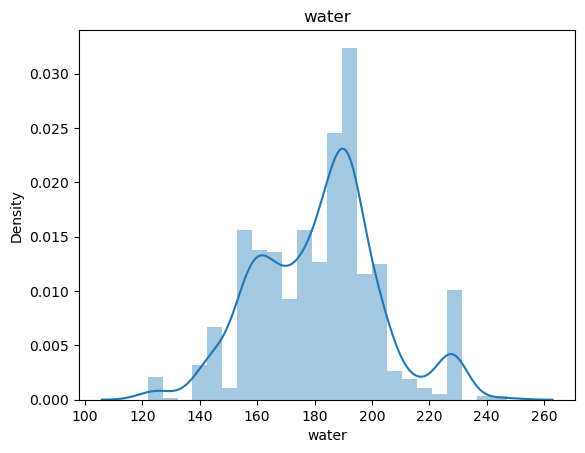

In [87]:
sns.distplot(df['water']).set_title('water');

In [88]:
# Slag
S_Q1 = df['slag'].quantile(q=0.25)
S_Q3 = df['slag'].quantile(q=0.75)

In [89]:
LS_outliers = S_Q1-1.5*(S_Q3-S_Q1)
US_outliers = S_Q3+1.5*(S_Q3-S_Q1)
print('Lower outlier in slag', LS_outliers)
print('Upper outlier in slag', US_outliers)

Lower outlier in slag -214.42499999999998
Upper outlier in slag 357.375


In [90]:
print('Number of outlier in cement Upper: ',df[df['slag']>357.375]['slag'].count())
print('Number of outlier in cement Lower: ',df[df['slag']<-214.425]['slag'].count())

Number of outlier in cement Upper:  2
Number of outlier in cement Lower:  0


<IPython.core.display.Javascript object>

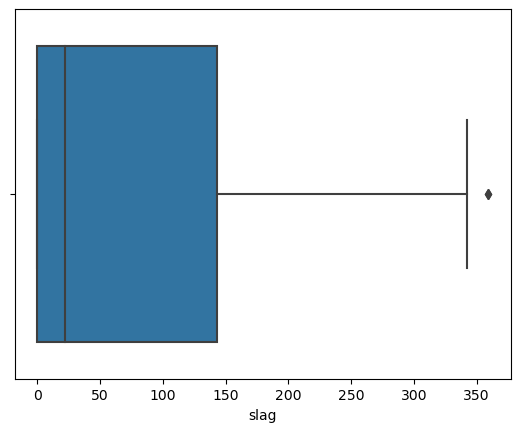

In [91]:
sns.boxplot(x='slag',data=df); 

In [92]:
# Age 
A_Q1 = df['age'].quantile(q=0.25)
A_Q3 = df['age'].quantile(q=0.75)

In [93]:
LA_outliers = A_Q1-1.5*(A_Q3-A_Q1)
UA_outliers = A_Q3+1.5*(A_Q3-A_Q1)
print('Lower outlier in age', LA_outliers)
print('Upper outlier in age', UA_outliers)

Lower outlier in age -66.5
Upper outlier in age 129.5


In [94]:
print('Number of outlier in age Upper: ',df[df['age']>129.5]['age'].count())
print('Number of outlier in age Lower: ',df[df['age']<-66.5]['age'].count())

Number of outlier in age Upper:  59
Number of outlier in age Lower:  0


<IPython.core.display.Javascript object>

<Axes: xlabel='age'>

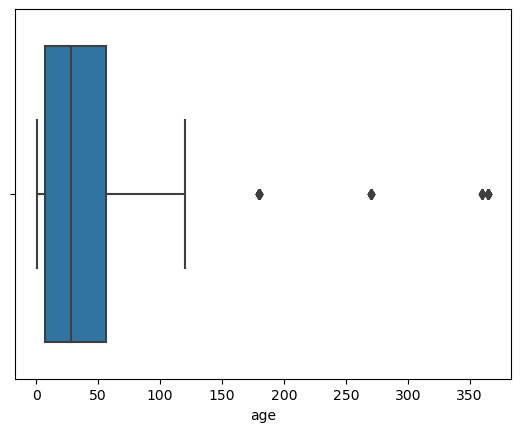

In [95]:
sns.boxplot(x='age',data=df)

In [96]:
# Ash 
As_Q1 = df['ash'].quantile(q=0.25)
As_Q3 = df['ash'].quantile(q=0.75)

In [97]:
LAs_outliers = As_Q1-1.5*(As_Q3-As_Q1)
UAs_outliers = As_Q3+1.5*(As_Q3-As_Q1)
print('Lower outlier in ash', LAs_outliers)
print('Upper outlier in ash', UAs_outliers)

Lower outlier in ash -177.45
Upper outlier in ash 295.75


In [98]:
print('Number of outlier in ash Upper: ',df[df['ash']>295.75]['ash'].count())
print('Number of outlier in ash Lower: ',df[df['ash']<-177.45]['ash'].count())

Number of outlier in ash Upper:  0
Number of outlier in ash Lower:  0


<IPython.core.display.Javascript object>

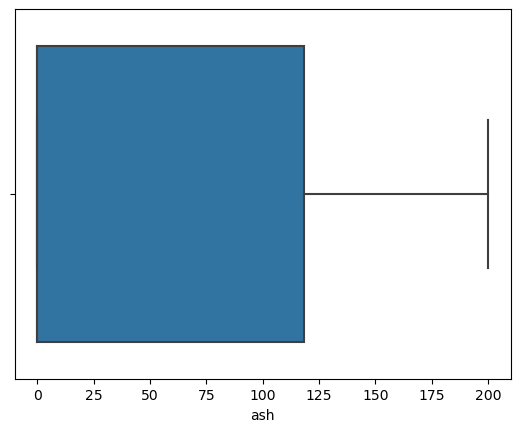

In [99]:
sns.boxplot(x='ash',data=df);

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

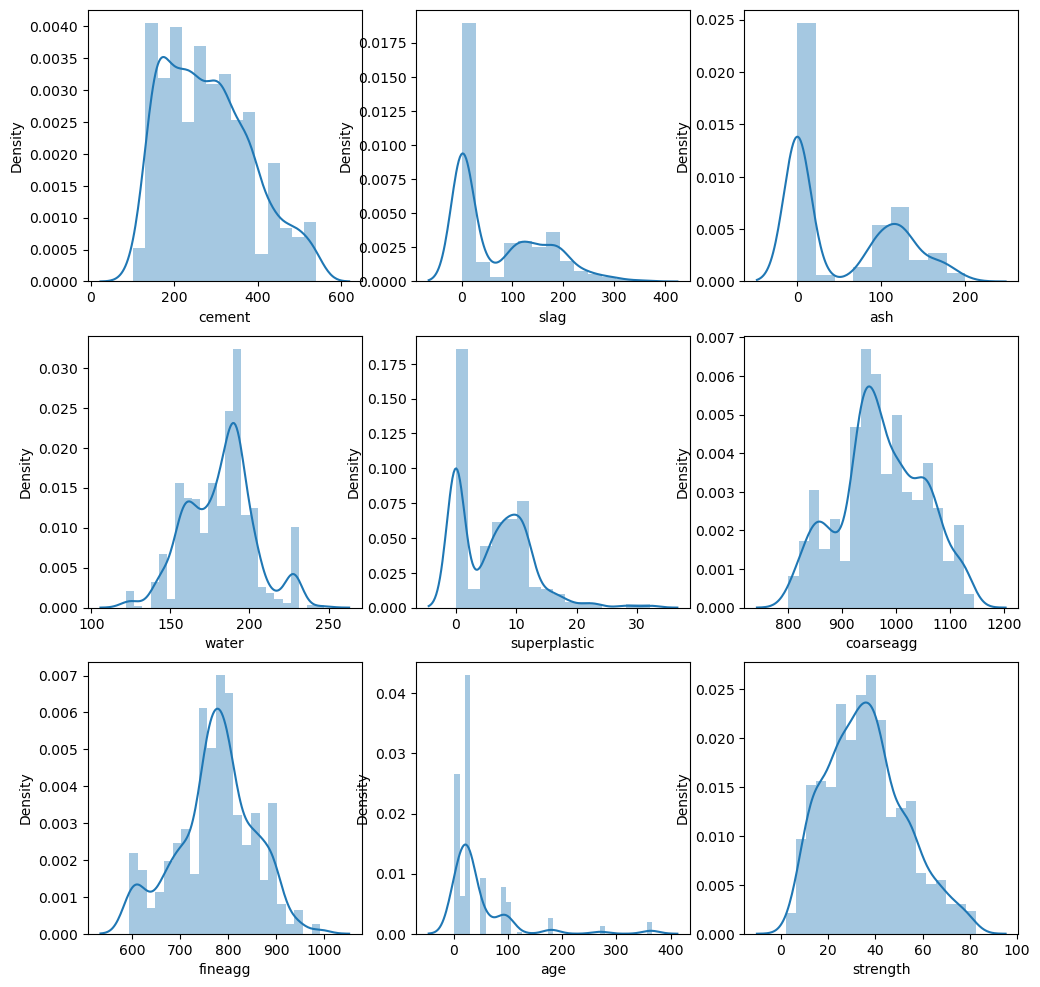

In [100]:
fig, ax2 = plt.subplots(3,3, figsize=(12,12))
sns.distplot(df['cement'], ax=ax2[0][0])
sns.distplot(df['slag'], ax=ax2[0][1])
sns.distplot(df['ash'], ax=ax2[0][2])
sns.distplot(df['water'], ax=ax2[1][0])
sns.distplot(df['superplastic'], ax=ax2[1][1])
sns.distplot(df['coarseagg'], ax=ax2[1][2])
sns.distplot(df['fineagg'], ax=ax2[2][0])
sns.distplot(df['age'], ax=ax2[2][1])
sns.distplot(df['strength'], ax=ax2[2][2]);

<IPython.core.display.Javascript object>

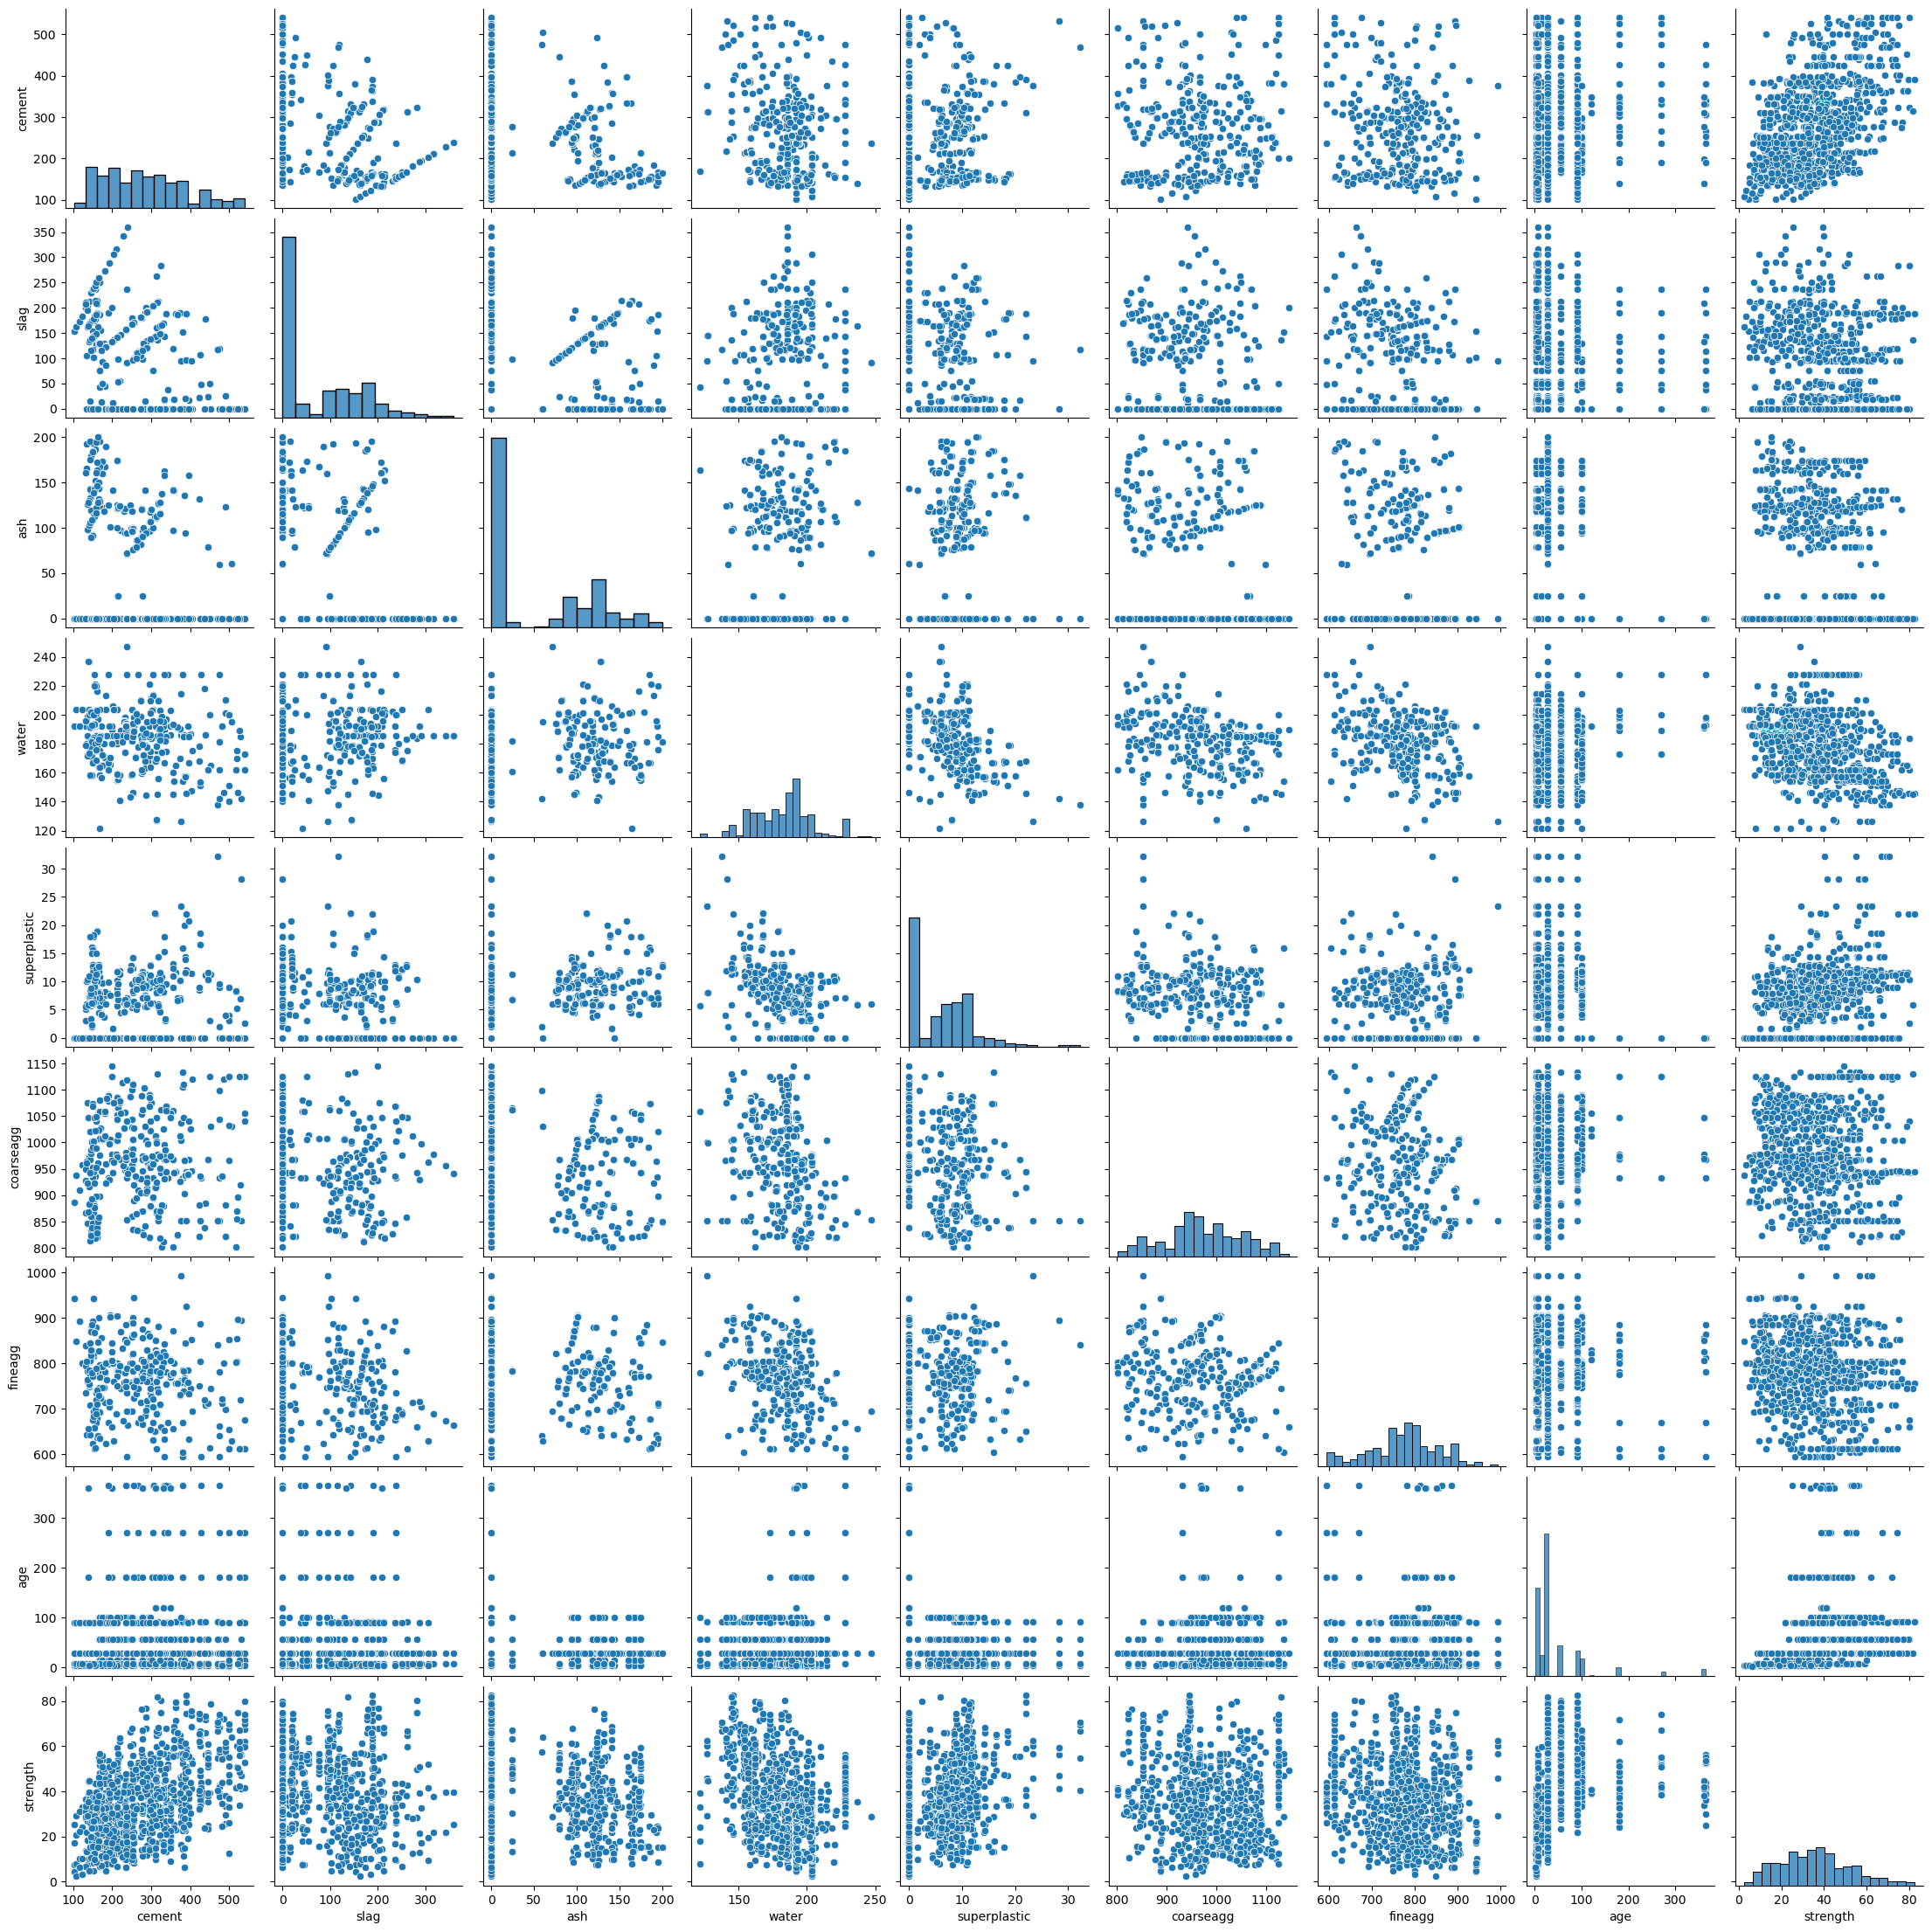

In [101]:
sns.pairplot(df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

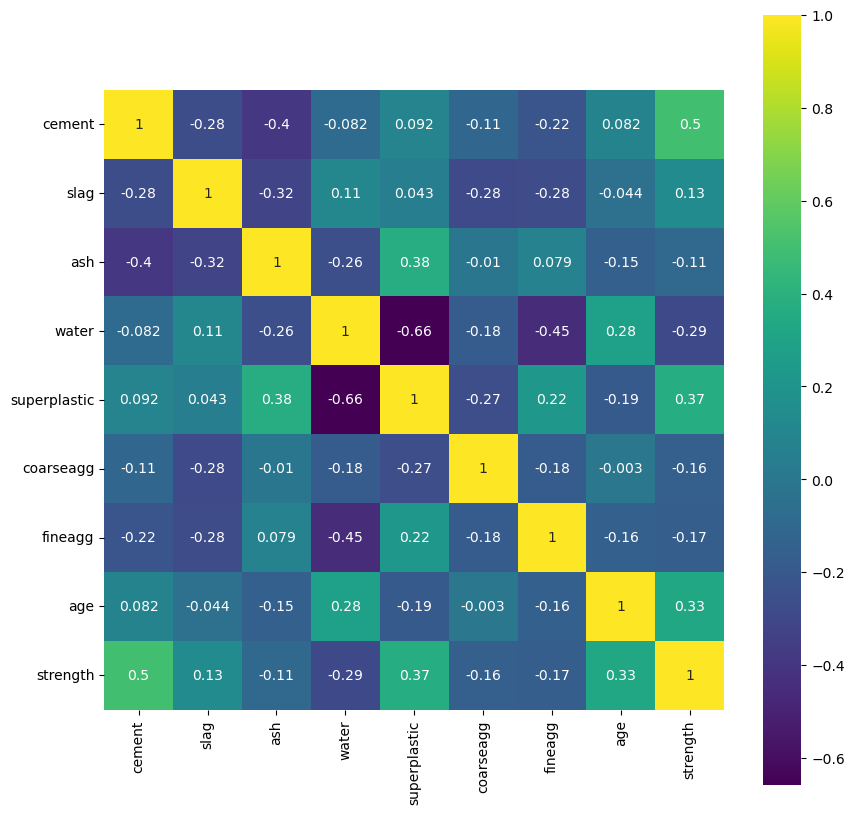

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),square=True,annot=True,cmap='viridis');

<Axes: >

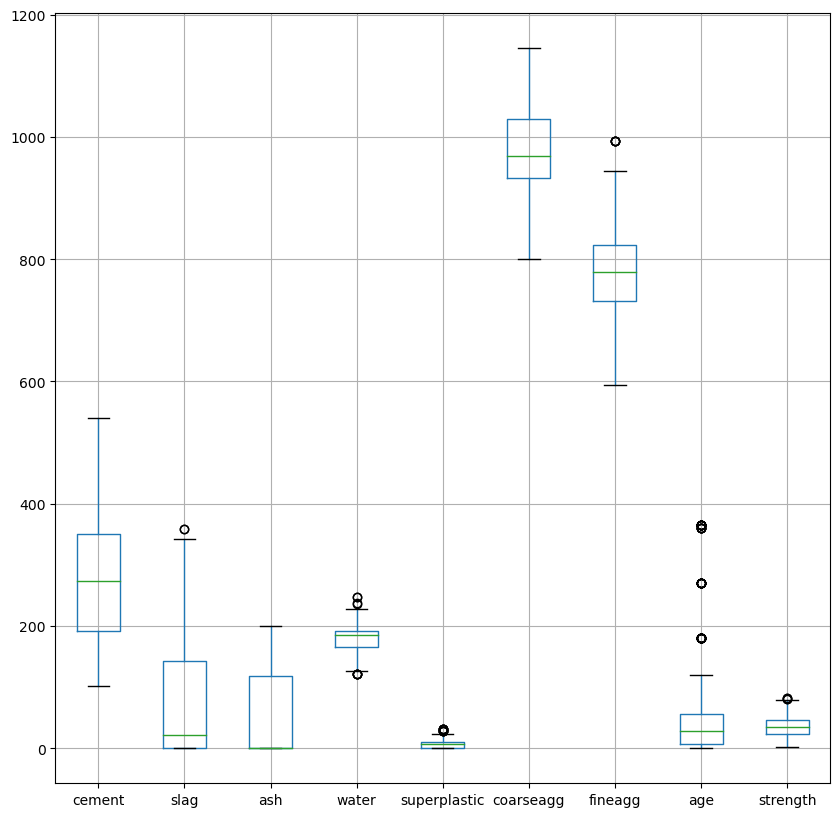

In [103]:
df.boxplot(figsize=(10,10))

In [104]:
print('outlier in cement: ',df[((df.cement-df.cement.mean())/df.cement.std()).abs()>3]['cement'].count())
print('outlier in slag : ',df[((df.slag-df.slag.mean())/df.slag.std()).abs()>3]['slag'].count())
print('outlier in ash : ',df[((df.ash-df.ash.mean())/df.ash.std()).abs()>3]['ash'].count())
print('outlier in water: ',df[((df.water-df.water.mean())/df.water.std()).abs()>3]['water'].count())
print('outlier in superplastic: ',df[((df.superplastic-df.superplastic.mean())/df.superplastic.std()).abs()>3]['superplastic'].count())
print('outlier in  coarseagg: ',df[((df.coarseagg-df.coarseagg.mean())/df.coarseagg.std()).abs()>3]['coarseagg'].count())
print('outlier in fineagg: ',df[((df.fineagg-df.fineagg.mean())/df.fineagg.std()).abs()>3]['fineagg'].count())
print('outlier in age: ',df[((df.age-df.age.mean())/df.age.std()).abs()>3]['age'].count())

outlier in cement:  0
outlier in slag :  4
outlier in ash :  0
outlier in water:  2
outlier in superplastic:  10
outlier in  coarseagg:  0
outlier in fineagg:  0
outlier in age:  33


In [105]:
for cols in df.columns[:-1]:
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    iqr = Q3-Q1
    
    low = Q1-1.5*iqr
    high = Q3+1.5*iqr
    df.loc[(df[cols]<low) | (df[cols]>high), cols] = df[cols].median()

<Axes: >

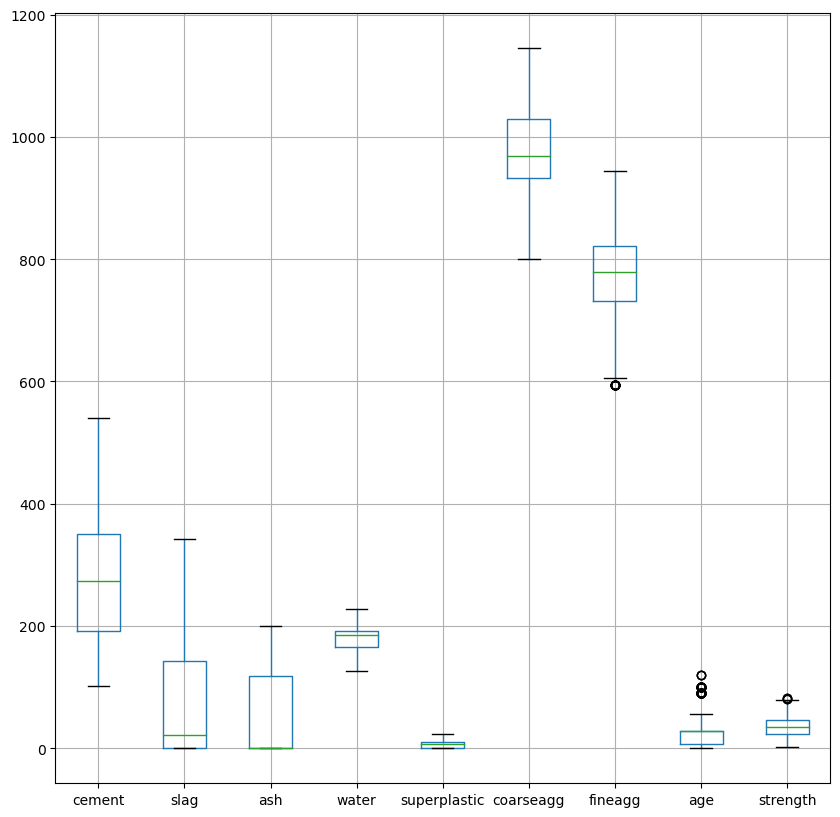

In [106]:
df.boxplot(figsize=(10,10))

## Feature Engineering & Model Building

In [107]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,28,44.30


In [108]:
X = df.drop('strength',axis=1)
y = df['strength']

In [109]:
from scipy.stats import zscore

Xscaled = X.apply(zscore)
Xscaled_df = pd.DataFrame(Xscaled,columns=df.columns)

<IPython.core.display.Javascript object>

In [110]:
X_train,X_test,y_train,y_test = train_test_split(Xscaled,y, test_size=0.3,random_state=1)

## Buildning Different Models

### 1) Random Forest Regressor

In [111]:
r_model = RandomForestRegressor()
r_model.fit(X_train,y_train)

RandomForestRegressor()

In [112]:
y_pred = r_model.predict(X_test)

In [113]:
r_model.score(X_train,y_train)

0.9813593826598787

In [114]:
r_model.score(X_test,y_test)

0.8749308241718244

In [115]:
acc_r = metrics.r2_score(y_test,y_pred)
acc_r

0.8749308241718244

In [116]:
metrics.mean_squared_error(y_test,y_pred)

32.78153135923956

In [117]:
result_1 = pd.DataFrame({'Algorithm': ['Random Forest'], 'accuracy': acc_r}, index=[1])
results = result_1[['Algorithm', 'accuracy']]                          
results


<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931


### 2) Random Forest Regressor KFold cross validation

In [118]:
k = 20

# Creating a KFold object with shuffling enabled
kfold = KFold(n_splits=k, shuffle=True, random_state=70)

# Performing cross-validation
K_results = cross_val_score(r_model, X, y, cv=kfold)

# Calculating the mean accuracy
accuracy = np.mean(abs(K_results))
accuracy


<IPython.core.display.Javascript object>

0.90800275513443

In [119]:
K_results

array([0.92394956, 0.91923376, 0.92515749, 0.92121979, 0.91221597,
       0.82588648, 0.8983325 , 0.91807845, 0.90700197, 0.90937527,
       0.88993741, 0.91358111, 0.93578433, 0.937698  , 0.89746282,
       0.92773728, 0.92042064, 0.90609291, 0.92756897, 0.84332038])

In [120]:
random_re = pd.DataFrame({'Algorithm': ['Random Forest K_fold'], 'accuracy': accuracy}, index=[2])
results = pd.concat([results, random_re])
results = results[['Algorithm', 'accuracy']]
results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003


### 3) Gradient Boosting Regressor

In [121]:
g_model = GradientBoostingRegressor()
g_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [122]:
gy_pred = g_model.predict(X_test)

In [123]:
g_model.score(X_train,y_train)

0.9477368610390589

In [124]:
acc_g = metrics.r2_score(y_test,gy_pred)
acc_g

0.8802645307770954

In [125]:
g_model.score(X_test,y_test)

0.8802645307770954

In [126]:
metrics.mean_squared_error(y_test,gy_pred)

31.38352846057264

In [127]:
gradient_re = pd.DataFrame({'Algorithm':['GradientBoostingRegressor'],'accuracy':acc_g},index=['3'])
results = pd.concat([results,gradient_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265


### 4) Gradient Boosting Regressor KFold cross validation

In [128]:
k=20

kfold = KFold(n_splits=k,shuffle=True,random_state=70)
G_results = cross_val_score(g_model,X,y,cv=kfold)
g_accuracy = np.mean(abs(G_results))
g_accuracy

<IPython.core.display.Javascript object>

0.8975240781019671

In [129]:
gradient_k = pd.DataFrame({'Algorithm':['GradientBoostingRegressor KFold'],'accuracy':g_accuracy},index=['4'])
results = pd.concat([results,gradient_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524


### 5) Ada Boosting Regressor

In [130]:
ada_model = AdaBoostRegressor()
ada_model.fit(X_train,y_train)

AdaBoostRegressor()

In [131]:
aday_pred = g_model.predict(X_test)

In [132]:
ada_model.score(X_train,y_train)

0.8198693165713878

In [133]:
acc_ada = metrics.r2_score(y_test,aday_pred)
acc_ada

0.8802645307770954

In [134]:
ada_model.score(X_test,y_test)

0.7526594717556795

In [135]:
metrics.mean_squared_error(y_test,aday_pred)

31.38352846057264

In [136]:
ada_re = pd.DataFrame({'Algorithm':['AdaBoostRegressor'],'accuracy':acc_ada},index= ['5'])
results = pd.concat([results,ada_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265


### 6) Ada Boosting Regressor KFold cross validation

In [137]:
k=20

kfold = KFold(n_splits=k,shuffle=True,random_state=70)
ada_results = cross_val_score(ada_model,X,y,cv=kfold)
ada_accuracy = np.mean(abs(ada_results))
ada_accuracy

<IPython.core.display.Javascript object>

0.7761037894099327

In [138]:
ada_k = pd.DataFrame({'Algorithm':['Ada BoostingRegressor KFold'],'accuracy':ada_accuracy},index=['6'])
results = pd.concat([results,ada_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104


### 7) KNN Regression

In [139]:
diff_k=[]
for i in range(1,45):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i=knn.predict(X_test)
    diff_k.append(np.mean(pred_i!=y_test))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

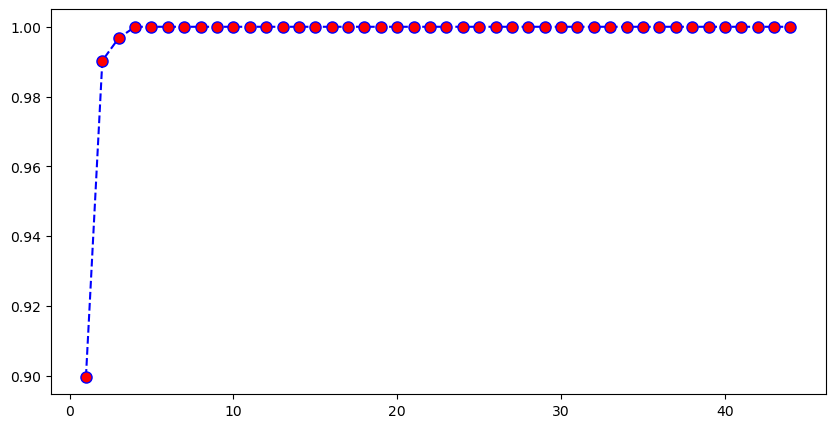

In [140]:
plt.figure(figsize=(10,5))
plt.plot(range(1,45),diff_k,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=8)

In [141]:
k_model = KNeighborsRegressor(n_neighbors=3)
k_model.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=3)

In [142]:
ky_pred = k_model.predict(X_test)

In [143]:
k_model.score(X_train,y_train)

0.9069857173257587

In [144]:
acc_k = metrics.r2_score(y_test,ky_pred)
acc_k

0.7538075164015781

In [145]:
k_model.score(X_test,y_test)

0.7538075164015781

In [146]:
metrics.mean_squared_error(y_test,ky_pred)

64.52882229413879

In [147]:
k_re = pd.DataFrame({'Algorithm':['KNeighborsRegressor'],'accuracy':acc_k},index=['7'])
results = pd.concat([results,k_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808


### 8) KNN Regression KFold Validation

In [148]:
k=20

kfold = KFold(n_splits=k,shuffle=True,random_state=70)
knn_results = cross_val_score(k_model,X,y,cv=kfold)
knn_accuracy = np.mean(abs(knn_results))
knn_accuracy

<IPython.core.display.Javascript object>

0.7050124120906828

In [149]:
knn_k = pd.DataFrame({'Algorithm':['KNN KFold'],'accuracy':knn_accuracy},index=['8'])
results = pd.concat([results,knn_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012


### 9) Bagging Regressor

In [150]:
b_model = BaggingRegressor()
b_model.fit(X_train,y_train)

BaggingRegressor()

In [151]:
by_pred = b_model.predict(X_test)

In [152]:
b_model.score(X_train,y_train)

0.9733339878898166

In [153]:
acc_b = metrics.r2_score(y_test,by_pred)
acc_b

0.8536969538507027

In [154]:
b_model.score(X_test,y_test)

0.8536969538507027

In [155]:
metrics.mean_squared_error(y_test,by_pred)

38.347081633322915

In [156]:
b_re = pd.DataFrame({'Algorithm':['BaggingRegressor'],'accuracy':acc_b},index=['9'])
results = pd.concat([results,b_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012
9,BaggingRegressor,0.853697


### 10) Bagging Regressor KFold Validation

In [157]:
k=20

kfold = KFold(n_splits=k,shuffle=True, random_state=70)
b_results = cross_val_score(b_model,X,y,cv=kfold)
b_accuracy = np.mean(abs(b_results))
b_accuracy

<IPython.core.display.Javascript object>

0.9008010597992703

In [158]:
b_k = pd.DataFrame({'Algorithm':['BaggingRegressor Fold'],'accuracy':b_accuracy},index=['10'])
results = pd.concat([results,b_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012
9,BaggingRegressor,0.853697
10,BaggingRegressor Fold,0.900801


### 11) Support Vector Regressor

In [159]:
s_model = SVR(kernel='linear')
s_model.fit(X_train,y_train)

SVR(kernel='linear')

In [160]:
sy_pred = s_model.predict(X_test)

In [161]:
s_model.score(X_train,y_train)

0.7296525761559521

In [162]:
acc_s = metrics.r2_score(y_test,sy_pred)
acc_s

0.6549962611822545

In [163]:
s_model.score(X_test,y_test)

0.6549962611822545

In [164]:
metrics.mean_squared_error(y_test,sy_pred)

90.4279636306755

In [165]:
s_re = pd.DataFrame({'Algorithm':['SVRegressor'],'accuracy':acc_s},index=['11'])
results = pd.concat([results,s_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012
9,BaggingRegressor,0.853697
10,BaggingRegressor Fold,0.900801


### 12) Support Vector Regressor KFold Validation

In [166]:
k=20

kfold = KFold(n_splits=k,shuffle=True,random_state=70)
s_results = cross_val_score(s_model,X,y,cv=kfold)
s_accuracy = np.mean(abs(s_results))
s_accuracy

<IPython.core.display.Javascript object>

0.6972528851586114

In [167]:
s_k = pd.DataFrame({'Algorithm':['SVR Fold'],'accuracy':s_accuracy},index=['12'])
results = pd.concat([results,s_k])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012
9,BaggingRegressor,0.853697
10,BaggingRegressor Fold,0.900801


### 13) XGBoost Regressor

In [169]:
pip install xgboost


     ------------------------------------ 124.9/124.9 MB 535.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [170]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgr = XGBRegressor()

xgr.fit(X_train,y_train);

In [171]:
xy_pred = xgr.predict(X_test)

In [172]:
xgr.score(X_train,y_train)

0.992400687042809

In [173]:
acc_x = metrics.r2_score(y_test,xy_pred)
acc_x

0.8848170780709802

In [174]:
xgr.score(X_test,y_test)

0.8848170780709802

In [175]:
metrics.mean_squared_error(y_test,xy_pred)

30.19027304099638

In [176]:
x_re = pd.DataFrame({'Algorithm':['XGB Regressor'],'accuracy':acc_x},index=['13'])
results = pd.concat([results,x_re])
results = results[['Algorithm','accuracy']]
results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Algorithm,accuracy
1,Random Forest,0.874931
2,Random Forest K_fold,0.908003
3,GradientBoostingRegressor,0.880265
4,GradientBoostingRegressor KFold,0.897524
5,AdaBoostRegressor,0.880265
6,Ada BoostingRegressor KFold,0.776104
7,KNeighborsRegressor,0.753808
8,KNN KFold,0.705012
9,BaggingRegressor,0.853697
10,BaggingRegressor Fold,0.900801


Here, XGBoost Regressor gives maximum 90% Accuracy.